<a href="https://colab.research.google.com/github/alexunderch/Bachelor_materials/blob/main/learning_jax/Flax_primitives.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flax basics

In [1]:
!pip install --upgrade -q "jax[cuda11_cudnn805]" -f https://storage.googleapis.com/jax-releases/jax_releases.html
!pip install --upgrade -q git+https://github.com/google/flax.git

import jax
from jax import lax, random, numpy as jnp

# NN lib built on top of JAX developed by Google Research (Brain team)
# Flax was "designed for flexibility" hence the name (Flexibility + JAX -> Flax)
# thanks to https://github.com/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_4_Flax_Zero2Hero_Colab.ipynb for this tutorial
# I post it on my own github just to have started!

import flax
from flax.core import freeze, unfreeze
from flax import linen as nn  # nn notation also used in PyTorch and in Flax's older API
from flax.training import train_state  # a useful dataclass to keep train state

import optax

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import functools  # useful utilities for functional programs
from typing import Any, Callable, Sequence, Optional

import numpy as np
import matplotlib.pyplot as plt

     |████████████████████████████████| 136 kB 5.4 MB/s 
     |████████████████████████████████| 70 kB 4.2 MB/s 


## How it works:

In [13]:
#just a simple layer like logistic regression
model = nn.Dense(features = 5, use_bias = True)

#### init function ####
seed = 42
key1, key2 = jax.random.split(jax.random.PRNGKey(seed))
x = jax.random.normal(key1, (10,)) #dummy input

y, params = model.init_with_output(key2, x)
print(y)
#or
params = model.init(key2, x)

# 1) automatic shape inference
# 2) immutable data structures
# 3) ... 
print(jax.tree_map(lambda x: x.shape, params))

#### apply function ####
y = model.apply(params, x) ##even prediction id stateful (a state is external!)
print(y)


[-0.06848565  0.7341108  -0.10687529  0.59046155  0.6236681 ]
FrozenDict({
    params: {
        bias: (5,),
        kernel: (10, 5),
    },
})
[-0.06848565  0.7341108  -0.10687529  0.59046155  0.6236681 ]


## A Simple Linear Regression Model 

In [14]:
#creating a toy dataset
n_samples = 150
x_dim = 2; y_dim = 1
noise_ratio = .1

key, w_key, b_key = jax.random.split(jax.random.PRNGKey(seed), num = 3)

W = jax.random.normal(key = w_key, shape = (x_dim, y_dim))
b = jax.random.normal(key = b_key, shape = (y_dim, ))

#params tree model will predict
true_params = freeze({"params": {
                                  "bias": b,
                                  "weight": W
                                }    
                      })

#generating samples
key, x_key, noise_key = jax.random.split(jax.random.PRNGKey(seed), num =3)
xs = jax.random.normal(key = x_key, shape = (n_samples, x_dim))
ys = jnp.dot(xs, W) + b +\
      noise_ratio * jax.random.normal(noise_key, (n_samples, y_dim))

print(f"Created dataset has {n_samples} samples \nwith the data xs shape = {xs.shape} and labels ys shape = {ys.shape}")



Created dataset has 150 samples 
with the data xs shape = (150, 2) and labels ys shape = (150, 1)


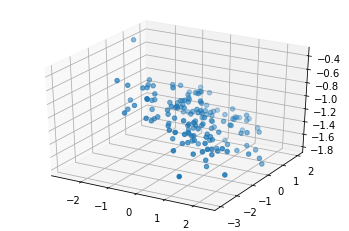

In [15]:
# Let's visualize our data (becoming one with the data paradigm <3)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
assert xs.shape[-1] == 2 and ys.shape[-1] == 1  # low dimensional data so that we can plot it
ax.scatter(xs[:, 0], xs[:, 1], zs=ys)

In [21]:
def make_mse_loss(xs, ys):
    def mse_loss(params):
        def squared_error(x, y):
            pred = model.apply(params, x)
            return jnp.inner(y - pred, y - pred) * .5
        # batching with `vmap` and averaging
        return jnp.mean(jax.vmap(squared_error)(xs, ys), axis = 0)
    return jax.jit(mse_loss) #pure function as the result

mse_loss = make_mse_loss(xs, ys)
value_and_grad_fn = jax.value_and_grad(mse_loss)

In [22]:
#a simple model
model = nn.Dense(features = y_dim)
params = model.init(key, xs)
print(f"Initial model params: {params}")

#a simple training loop
lr = 0.3
epochs = 20
log_period_epoch = 5

print('-' * 50)
for epoch in range(epochs):
    loss, grads = value_and_grad_fn(params)
    # SGD 
    params = jax.tree_multimap(lambda p, g: p - lr * g, params, grads)
    if epoch % log_period_epoch == 0: print(f'epoch {epoch}, loss = {loss}')

print('-' * 50)
print(f'Learned params = {params}')
print(f'Gt params = {true_params}')

Initial model params: FrozenDict({
    params: {
        kernel: DeviceArray([[0.08270834],
                     [1.2298492 ]], dtype=float32),
        bias: DeviceArray([0.], dtype=float32),
    },
})
--------------------------------------------------
epoch 0, loss = 1.5225977897644043
epoch 5, loss = 0.05163402855396271
epoch 10, loss = 0.007201272062957287
epoch 15, loss = 0.005720613058656454
--------------------------------------------------
Learned params = FrozenDict({
    params: {
        bias: DeviceArray([-1.2147812], dtype=float32),
        kernel: DeviceArray([[-0.20982888],
                     [ 0.00534452]], dtype=float32),
    },
})
Gt params = FrozenDict({
    params: {
        bias: DeviceArray([-1.2226542], dtype=float32),
        weight: DeviceArray([[-0.21746705],
                     [ 0.0102447 ]], dtype=float32),
    },
})


In [23]:
from jax._src.lax.lax import le
opt_sgd = optax.sgd(learning_rate = lr, nesterov = True)
opt_state = opt_sgd.init(params)
print(opt_state) #doesn't have a state


opt_adam = optax.adam(learning_rate=lr)
opt_state_adam = opt_adam.init(params)
print(opt_state_adam)

(EmptyState(), EmptyState())
(ScaleByAdamState(count=DeviceArray(0, dtype=int32), mu=FrozenDict({
    params: {
        bias: DeviceArray([0.], dtype=float32),
        kernel: DeviceArray([[0.],
                     [0.]], dtype=float32),
    },
}), nu=FrozenDict({
    params: {
        bias: DeviceArray([0.], dtype=float32),
        kernel: DeviceArray([[0.],
                     [0.]], dtype=float32),
    },
})), EmptyState())


In [27]:
params = model.init(key, xs)  # let's start with fresh params again

for epoch in range(epochs):
    loss, grads = value_and_grad_fn(params)
    updates, opt_state_adam = opt_adam.update(grads, opt_state_adam)  # arbitrary optim logic
    params = optax.apply_updates(params, updates)

    if epoch % log_period_epoch == 0:
        print(f'epoch {epoch}, loss = {loss}')

epoch 0, loss = 1.5225977897644043
epoch 5, loss = 0.04835254326462746
epoch 10, loss = 0.2879025340080261
epoch 15, loss = 0.012076061218976974


Example from Flax (ImageNet example)
https://github.com/google/flax/blob/main/examples/imagenet/train.py#L88
```Python
def create_learning_rate_fn(
    config: ml_collections.ConfigDict,
    base_learning_rate: float,
    steps_per_epoch: int):
  """Create learning rate schedule."""
  warmup_fn = optax.linear_schedule(
      init_value=0., end_value=base_learning_rate,
      transition_steps=config.warmup_epochs * steps_per_epoch)
  cosine_epochs = max(config.num_epochs - config.warmup_epochs, 1)
  cosine_fn = optax.cosine_decay_schedule(
      init_value=base_learning_rate,
      decay_steps=cosine_epochs * steps_per_epoch)
  schedule_fn = optax.join_schedules(
      schedules=[warmup_fn, cosine_fn],
      boundaries=[config.warmup_epochs * steps_per_epoch])
  return schedule_fn

tx = optax.sgd(
      learning_rate=learning_rate_fn,
      momentum=config.momentum,
      nesterov=True)

# Example from Haiku (ImageNet example)
# https://github.com/deepmind/dm-haiku/blob/main/examples/imagenet/train.py#L116
def make_optimizer() -> optax.GradientTransformation:
  """SGD with nesterov momentum and a custom lr schedule."""
  return optax.chain(
      optax.trace(
          decay=FLAGS.optimizer_momentum,
          nesterov=FLAGS.optimizer_use_nesterov),
      optax.scale_by_schedule(lr_schedule), optax.scale(-1))
```

## Creating own MLP

In [29]:
class MLP(nn.Module):
  num_neurons_per_layer: Sequence[int] 
  #check out https://realpython.com/python-data-classes/
  def setup(self):
      """new __init__()"""
      self.layers = [nn.Dense(n) for n in self.num_neurons_per_layer]
      
  def __call1__(self, x):
    act = x
    for i, layer in enumerate(self.layers):
        act = layer(act)
        if i != len(self.layers) - 1: act = nn.relu(act)
    return act

  @nn.compact #more concise way
  def __call__(self, x):
    act = x
    for i, neurons in enumerate(self.num_neurons_per_layer):
        act = nn.Dense(neurons)(act)
        if i != len(self.num_neurons_per_layer) - 1: act = nn.relu(act)
    return act

x_key, init_key = jax.random.split(jax.random.PRNGKey(seed))

model = MLP(num_neurons_per_layer = [16, 8, 1])
x = jax.random.uniform(x_key, (4, 4))
params = model.init(init_key, x)
y = model.apply(params, x)
print(jax.tree_map(jnp.shape, params))

FrozenDict({
    params: {
        Dense_0: {
            bias: (16,),
            kernel: (4, 16),
        },
        Dense_1: {
            bias: (8,),
            kernel: (16, 8),
        },
        Dense_2: {
            bias: (1,),
            kernel: (8, 1),
        },
    },
})


## Designing a `module` (flax param — "trainable parameter")

In [30]:
class MyDenseModule(nn.Module):
    num_neurons: int
    weight_init: Callable = nn.initializers.kaiming_normal()
    bias_init: Callable = nn.initializers.zeros

    @nn.compact
    def __call__(self, x):
        weight = self.param(
                            "WeIgHt", #name in model params dict
                            self.weight_init, #initialization function (implicit)
                            (x.shape[-1], self.num_neurons)#shape info
                            )
        bias = self.param("BiAs", self.bias_init, (self.num_neurons,))
        return jnp.dot(x, weight) + bias

x_key, init_key = random.split(random.PRNGKey(seed))

model = MyDenseModule(num_neurons=3)  # initialize the model
x = random.uniform(x_key, (4,4))  # dummy input
params = model.init(init_key, x)  # initialize via init
y = model.apply(params, x)  # do a forward pass via apply

print(jax.tree_map(jnp.shape, params))      
    

FrozenDict({
    params: {
        BiAs: (3,),
        WeIgHt: (4, 3),
    },
})


In [31]:
from inspect import signature
print(signature(nn.initializers.lecun_normal()))

(key, shape, dtype=<class 'jax._src.numpy.lax_numpy.float64'>)


### Variable
It is the broader concept of trainable or non-trainable params

In [34]:
class BiasAdderWithRunningMean(nn.Module): 
    decay: float  = .99
    
    @nn.compact
    def __call__(self, x):
        is_initialized = self.has_variable("batch_stats", "ema")
        # 'batch_stats' is not an arbitrary name (non-trainable params collection)
        ema = self.variable("batch_stats", #name of collection
                            "ema",
                            lambda shape: jnp.zeros(shape), x.shape[1:])

        bias = self.param("bias", lambda key, shape: jnp.zeros(shape), x.shape[1:])

        if is_initialized: 
            ema.value = self.decay * ema.value + (1. - self.decay) * jnp.mean(x, axis = 0, keepdims = True)

        return x - ema.value + bias

x_key, init_key = random.split(random.PRNGKey(seed))

model = BiasAdderWithRunningMean()
x = random.uniform(x_key, (10,4))  # dummy input
variables = model.init(init_key, x)
print(f'Multiple collections = {variables}') 

# We have to use mutable since regular params are not modified during the forward
# pass, but these variables are. We can't keep state internally (because JAX) so we have to return it.
y, updated_non_trainable_params = model.apply(variables, x, mutable = ['batch_stats'])
print(updated_non_trainable_params)

Multiple collections = FrozenDict({
    batch_stats: {
        ema: DeviceArray([0., 0., 0., 0.], dtype=float32),
    },
    params: {
        bias: DeviceArray([0., 0., 0., 0.], dtype=float32),
    },
})
FrozenDict({
    batch_stats: {
        ema: DeviceArray([[0.00382814, 0.005208  , 0.00427174, 0.00396865]], dtype=float32),
    },
})


In [35]:
def update_step(opt, apply_fn, x, opt_state, params, non_trainable_params):

    def loss_fn(params):
        y, updated_non_trainable_params = apply_fn(
            {'params': params, **non_trainable_params}, 
            x, mutable = list(non_trainable_params.keys()))
        
        loss = ((x - y) ** 2).mean()  

        return loss, updated_non_trainable_params #making these parammeters explicitly mutable

    (loss, non_trainable_params), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    
    return opt_state, params, non_trainable_params

model = BiasAdderWithRunningMean()
x = jnp.ones((10, 4))

variables = model.init(random.PRNGKey(seed), x)
non_trainable_params, params = variables.pop('params') ###!!!!!!!!!!!!
del variables  

sgd_opt = optax.sgd(learning_rate=0.1)
opt_state = sgd_opt.init(params)

for _ in range(3):
    opt_state, params, non_trainable_params = update_step(sgd_opt, model.apply, x, opt_state, params, non_trainable_params)
    print(non_trainable_params)

FrozenDict({
    batch_stats: {
        ema: DeviceArray([[0.01, 0.01, 0.01, 0.01]], dtype=float32),
    },
})
FrozenDict({
    batch_stats: {
        ema: DeviceArray([[0.0199, 0.0199, 0.0199, 0.0199]], dtype=float32),
    },
})
FrozenDict({
    batch_stats: {
        ema: DeviceArray([[0.029701, 0.029701, 0.029701, 0.029701]], dtype=float32),
    },
})


### Own block

In [40]:
class DDNBlock(nn.Module):
    """Dense + dropout + batchnorm"""
    num_neurons: int
    training: bool

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.num_neurons)(x)
        x = nn.Dropout(rate = .5, deterministic = not self.training)(x)
        x = nn.BatchNorm(use_running_average = not self.training)(x)
        return x_dim


keys = jax.random.split(jax.random.PRNGKey(seed), num = 4)
model = DDNBlock(num_neurons = 6, training = True)
x = jax.random.uniform(keys[0], (6, 4, 4))


#explicitly having the separate keys for trainable and not trainable params
variables = model.init({'params': keys[1], 'dropout': keys[2]}, x)
print(variables)

y, non_trainable_params = model.apply(variables, x, 
                                      rngs = {'dropout': keys[3]}, #own rng for dropout!
                                      mutable = ['batch_stats'])
print(non_trainable_params)
#evaluation
eval_model = DDNBlock(num_neurons = 6, training = False)
y = eval_model.apply(variables, x)

FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[-0.18759   , -0.20207207,  0.484642  ,  0.1962698 ,
                           0.5483289 ,  0.6080119 ],
                         [ 0.11092687,  0.69150513, -0.5264836 ,  0.12288465,
                          -0.36953643, -0.14075957],
                         [-0.3233332 , -0.6288916 , -0.24624613,  0.1258726 ,
                          -0.40691987, -0.57214624],
                         [ 0.21232925, -0.25992277, -0.24564597,  0.3040609 ,
                          -0.3224999 ,  0.37073085]], dtype=float32),
            bias: DeviceArray([0., 0., 0., 0., 0., 0.], dtype=float32),
        },
        BatchNorm_0: {
            scale: DeviceArray([1., 1., 1., 1., 1., 1.], dtype=float32),
            bias: DeviceArray([0., 0., 0., 0., 0., 0.], dtype=float32),
        },
    },
    batch_stats: {
        BatchNorm_0: {
            mean: DeviceArray([0., 0., 0., 0., 0., 0.], dtype=float32),
            var: Devic

## A MNIST easy-peasy example (+ some `Dropout` and `BatchNorm`) !

In [4]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.8.0
Running on TPU  ['10.115.243.114:8470']


In [ ]:
###training loop is actually logical but still in debugging!
class CNN(nn.Module):  # lots of hardcoding, but it serves a purpose for a simple demo
    training: bool
    dropout_rate: float = 0.5
    
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.Dropout(rate = self.dropout_rate, deterministic = not self.training)(x)
        x = nn.BatchNorm(use_running_average = not self.training)(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.Dropout(rate = self.dropout_rate, deterministic = not self.training)(x)
        x = nn.BatchNorm(use_running_average = not self.training)(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        x = nn.log_softmax(x)
        return x

def custom_transform(x):
    # A couple of modifications here compared to tutorial #3 since we're using a CNN
    # Input: (28, 28) uint8 [0, 255] torch.Tensor, Output: (28, 28, 1) float32 [0, 1] np array
    return np.expand_dims(np.array(x, dtype=np.float32), axis=2) / 255.

def custom_collate_fn(batch):
    """Provides us with batches of numpy arrays and not PyTorch's tensors."""
    transposed_data = list(zip(*batch))

    labels = np.array(transposed_data[1])
    imgs = np.stack(transposed_data[0])

    return imgs, labels

mnist_img_size = (28, 28, 1)
batch_size = 128

train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data)
train_lbls = jnp.array(train_dataset.targets)

test_images = np.expand_dims(jnp.array(test_dataset.data), axis=3)
test_lbls = jnp.array(test_dataset.targets)

def compute_metrics(*, logits, gt_labels):
    one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)

    loss = -jnp.mean(jnp.sum(one_hot_gt_labels * logits, axis=-1))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == gt_labels)

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
    }
    return metrics

@jax.jit
def train_step(state, imgs, gt_labels, dropout_key):
    def loss_fn(params):
        _, key = jax.random.split(dropout_key)
        
        logits, _ = CNN(training = True).apply(state.params, 
                                            imgs,
                                            rngs = {"dropout": key},
                                            mutable = ['batch_stats'])
  
        one_hot_gt_labels = jax.nn.one_hot(gt_labels, num_classes=10)
        loss = -jnp.mean(jnp.sum(one_hot_gt_labels * logits, axis=-1))
        return loss, logits
  
    (_, logits), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)  # this is the whole update now! concise!
    metrics = compute_metrics(logits=logits, gt_labels=gt_labels)  # duplicating loss calculation but it's a bit cleaner
    return state, metrics

@jax.jit
def eval_step(state, imgs, gt_labels):
    logits = CNN(training = False).apply(state.params, imgs)
    return compute_metrics(logits=logits, gt_labels=gt_labels)

def create_train_state(key, learning_rate, momentum):
    cnn = CNN(training = True)
    keys = jax.random.split(key, num = 3)
    
    
    params = cnn.init({'params': keys[0], 'dropout': keys[1]}, jnp.ones([1, *mnist_img_size]))

    opt = optax.sgd(learning_rate, momentum)
    # TrainState is a simple built-in wrapper class that makes things a bit cleaner
    return train_state.TrainState.create(apply_fn = cnn.apply,
                                         params = params,
                                         tx = opt)

def train_one_epoch(state, dataloader, epoch, dropout_key):
    """Train for 1 epoch on the training set."""
    batch_metrics = []
    for cnt, (imgs, labels) in enumerate(dataloader):
        state, metrics = train_step(state, imgs, labels, dropout_key)
        batch_metrics.append(metrics)

    # Aggregate the metrics
    batch_metrics_np = jax.device_get(batch_metrics)  # pull from the accelerator onto host (CPU)
    epoch_metrics_np = {
        k: np.mean([metrics[k] for metrics in batch_metrics_np])
        for k in batch_metrics_np[0]
    }

    return state, epoch_metrics_np

def evaluate_model(state, test_imgs, test_lbls):
    """Evaluate on the validation set."""
    metrics = eval_step(state, test_imgs, test_lbls)
    metrics = jax.device_get(metrics)  # pull from the accelerator onto host (CPU)
    metrics = jax.tree_map(lambda x: x.item(), metrics)  # np.ndarray -> scalar
    return metrics

seed = 0  # needless to say these should be in a config or defined like flags
learning_rate = 0.1
momentum = 0.9
num_epochs = 5
batch_size = 32

key, dropout_key = jax.random.split(jax.random.PRNGKey(seed))
train_state_ = create_train_state(key, learning_rate, momentum)

for epoch in range(1, num_epochs + 1):
    
    train_state_, train_metrics = train_one_epoch(train_state_, train_loader, epoch,  jax.random.split(dropout_key)[-1])
    print(f"Train epoch: {epoch}, loss: {train_metrics['loss']}, accuracy: {train_metrics['accuracy'] * 100}")

    test_metrics = evaluate_model(train_state_, test_images, test_lbls)
    print(f"Test epoch: {epoch}, loss: {train_metrics['loss']}: {test_metrics['loss']}, accuracy: {test_metrics['accuracy'] * 100}")


Train epoch: 1, loss: 2.4606423377990723, accuracy: 7.698985189199448
Test epoch: 1, loss: 2.4606423377990723: 40.507041931152344, accuracy: 3.439999744296074


✅ Flax notebook (do follow along!): https://github.com/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_4_Flax_Zero2Hero_Colab.ipynb 

✅ Flax GitHub: https://github.com/google/flax 

✅ Flax docs: https://flax.readthedocs.io/en/latest/ 